In [374]:
import warnings
warnings.filterwarnings("ignore")

## Importing modules and Loading data

In [375]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder

csv_file="./insurance.csv"

data=pd.read_csv(csv_file)
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


<Axes: xlabel='sex', ylabel='charges'>

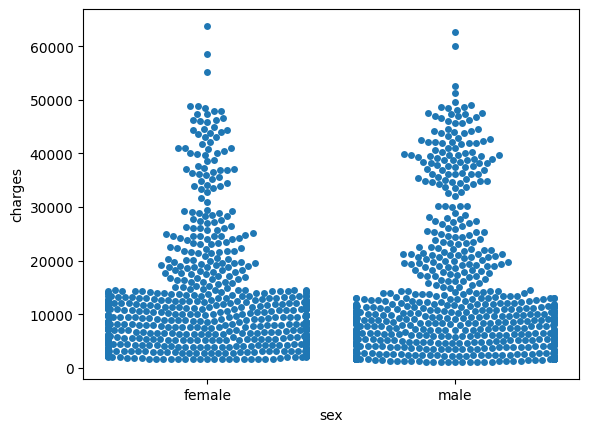

In [376]:
sns.swarmplot(data=data, y="charges", x="sex")

#### This chart shows no string correlation between region or sex and charges.

We may eliminate the region feature from our training at no noticeable cost to the accuracy of the model

<Figure size 1400x600 with 0 Axes>

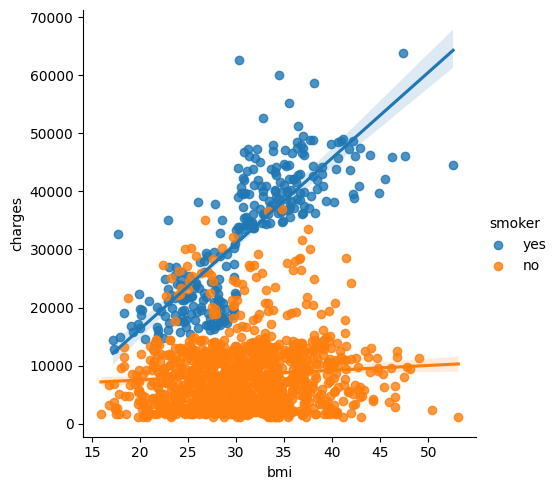

In [377]:
plt.figure(figsize=(14,6))
sns.lmplot(data=data,x="bmi", y="charges",hue="smoker")

#### We notice a notable proportinnality between BMI and medical charges
this correlation grows even stronger for smoking patients, therefore it is imperative that we consider these features when training the model

<Axes: xlabel='children', ylabel='charges'>

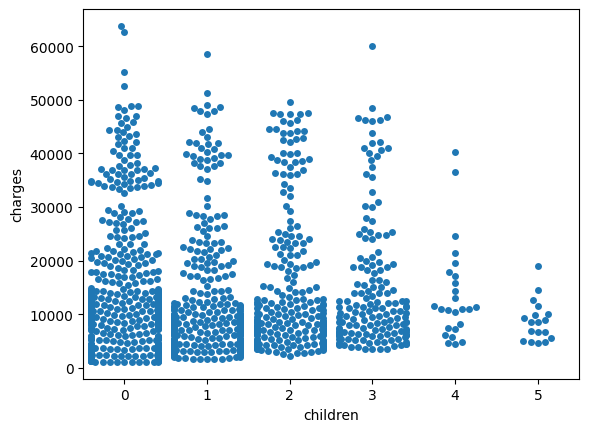

In [378]:
sns.swarmplot(data=data, y="charges", x="children")

#### It seels that people with less children are more likely to pay higher in medical charges

However, we need to consider that these interpretations may be skewed due to the higher number of childless people as opposed to those who have 4 or more.

For this model, we will still take it into account 

### Splitting data

In [379]:
y=data.charges
X=data.drop(columns=["charges", "region"])
object_cols=[col for col in X.columns if X[col].dtype=="object"]
num_cols=[col for col in X.columns if X[col].dtype in ("float64","int64")]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.15, train_size=0.85)

### Preprocessing numerical and categorical data, before fitting a RandomForestRegressor through a pipeline

In [380]:
preprocess_numerical = SimpleImputer(strategy="mean")

preprocess_objects = Pipeline(
    steps=[
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("encode", OrdinalEncoder()),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("numerical", preprocess_numerical, num_cols),
        ("object", preprocess_objects, object_cols),
    ]
)


model = Pipeline(
    steps=[
        ("preprocessing", preprocessor),
        ("model", RandomForestRegressor(n_estimators=250,max_leaf_nodes=10, random_state=5, n_jobs=6)),
    ]
)

model.fit(X_train, y_train)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numerical', SimpleImputer(),
                                                  ['age', 'bmi', 'children']),
                                                 ('object',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encode',
                                                                   OrdinalEncoder())]),
                                                  ['sex', 'smoker'])])),
                ('model',
                 RandomForestRegressor(max_leaf_nodes=10, n_estimators=250,
                                       n_jobs=6, random_state=5))])

In [381]:
predictions = model.predict(X_test)
cv_score = (cross_val_score(model, X, y, cv=10, scoring="neg_mean_absolute_error") * -1).mean()
prediction_score=mean_absolute_error(predictions,y_test)

## Comparing Mean avg error of our predictions and Cross-validation technique

<Axes: title={'center': 'Mean Average Error'}>

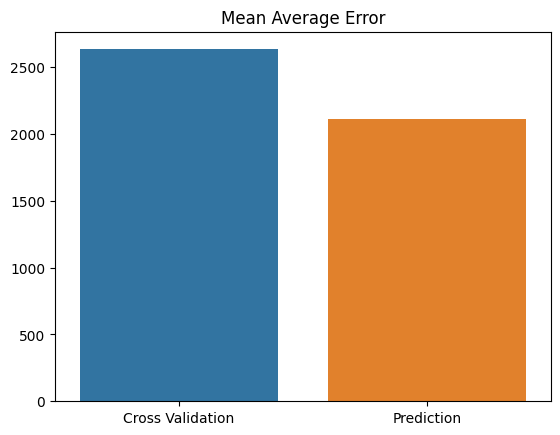

In [382]:
temp=pd.DataFrame({"Cross Validation" : cv_score , "Prediction": prediction_score}, index=[0])
plt.title("Mean Average Error")
sns.barplot(temp)


## Comparing prediction results to actual data

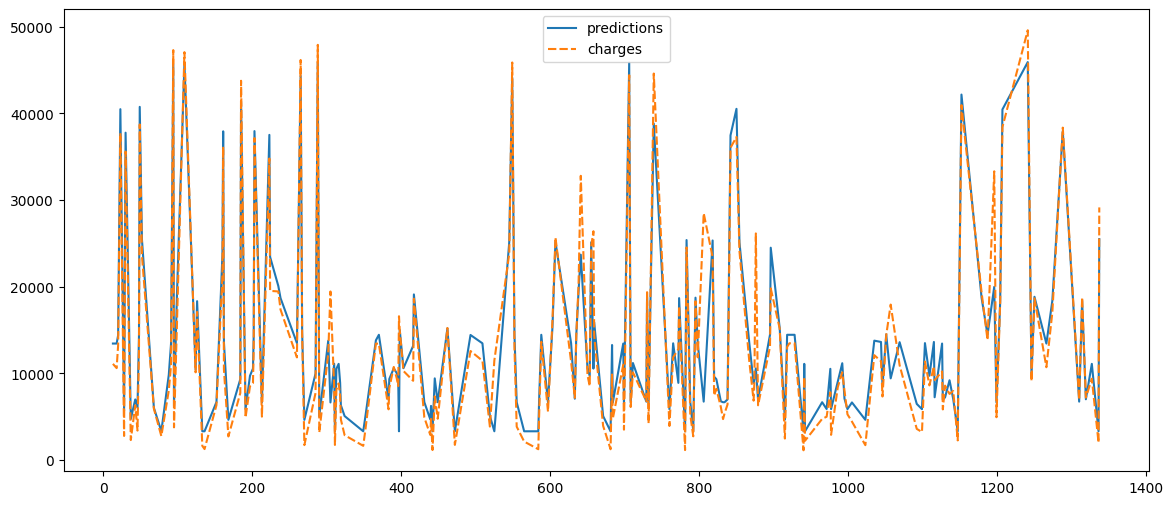

In [383]:
predictions=pd.Series(predictions)
predictions.index=y_test.index
#predictions.columns=y_test.columns
predictions.rename("predictions", inplace=True)

plt.figure(figsize=(14, 6))
sns.lineplot(data=[predictions, y_test])
plt.show()
